##### CIFAR-100

In [1]:
''' cifar-100 '''

import torch
import os
import pandas as pd
from IPython import display

archs = ['resnet18', 'vgg19', 'mobilenet_v2', 'resnext29_2x64d']
arch_names = ['RN18', 'VGG19', 'MBN_v2', 'RNX29']

table = []
budgets = [7.0, 10.0, 13.0]
for arch in archs:
    dirpath = f'./log/cifar100_{arch}_1.0'
    acc = torch.load(os.path.join(dirpath, 'ckpt.pth'))['acc']
    fr = torch.load(os.path.join(dirpath, 'baseline_00', 'ckpt.pth'))['fr']
    table.extend([acc, fr])
table = torch.tensor(table).view(len(archs), -1)

print('cifar-100')
table = pd.DataFrame(table, columns=['ACC', 'FR'], index=arch_names)
display.display(table)

cifar-100


,ACC,FR
RN18,79.730003,74.010002
VGG19,76.519997,66.620003
MBN_v2,72.160004,87.650002
RNX29,79.769997,70.809998


##### SPSA_MNIST_BUDGET

spsa_mnist_budget.sh


,0,1,2,3,4
Budget,10.00,33.42,56.84,75.57,99.00
FR (%),0.44,12.61,51.11,63.73,87.51


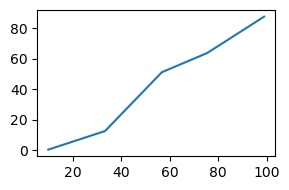

In [2]:
''' spsa_mnist_budget.sh '''

import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display

exproot = f'./log/mnist_toy_1.0/budgets'
budgets = sorted(os.listdir(exproot))
filenames = [os.path.join(exproot, b, 'ckpt.pth') for b in budgets]

budgets = list(map(float, budgets))
fr = [torch.load(fn)['fr'] for fn in filenames]

table = pd.DataFrame((budgets, fr), index=['Budget', 'FR (%)'])

print('spsa_mnist_budget.sh')
display.display(table)

plt.figure(figsize=(3, 2))
plt.plot(budgets, fr)
plt.tight_layout(); plt.show()

##### SPSA_BATCHSIZE_BUDGET

spsa_batchsize_budget.sh


,Batch Size,Epochs,FR (%),Time (s),# Updates
0,1,4,21.03,5131.373510,200000
1,32,128,83.39,5318.416736,199936
2,64,256,86.97,5608.165528,199936
3,128,512,85.99,4929.884037,199680
4,256,1025,87.71,11210.457494,199875
5,512,2061,87.40,22247.630779,199917


  0%|          | 0/6 [00:00<?, ?it/s]

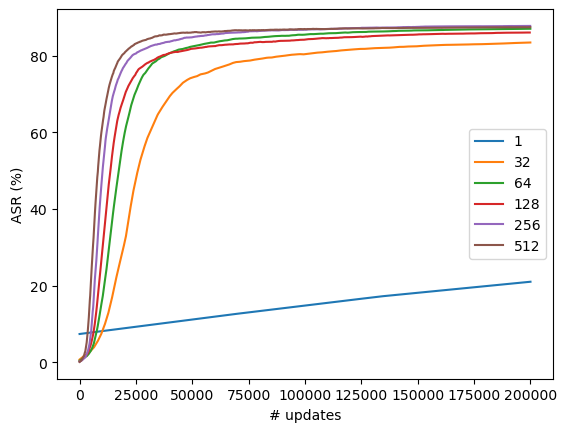

In [3]:
''' spsa_batchsize_budget.sh '''

import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from tqdm.auto import tqdm


def lerp(t: torch.Tensor, size: int) -> torch.Tensor:
    indices = torch.linspace(0, t.size(0) - 1, steps=size)
    lower_indices = indices.floor().long()
    upper_indices = torch.clamp(indices.ceil().long(), max=t.size(0) - 1)

    lower_values = t[lower_indices]
    upper_values = t[upper_indices]
    
    weights = indices - lower_indices.float()    
    interpolated_values = lower_values + weights * (upper_values - lower_values)
    
    return interpolated_values


exproot = f'./log/cifar10_resnet18_1.0/batch_time'
batch_size = sorted(os.listdir(exproot))
filenames = [os.path.join(exproot, b, 'ckpt.pth') for b in batch_size]
ckpts = [torch.load(fn) for fn in filenames]
get_fn = lambda key: [ckpt[key] for ckpt in ckpts]

batch_size = list(map(int, batch_size))
epochs = [ckpt['args']['epochs'] for ckpt in ckpts]
fr = [ckpt['fr'] for ckpt in ckpts]
time = [ckpt['time'] for ckpt in ckpts]
num_updates = [200000, 199936, 199936, 199680, 199875, 199917]

print('spsa_batchsize_budget.sh')
table = pd.DataFrame(zip(batch_size, epochs, fr, time, num_updates),
                     columns=['Batch Size', 'Epochs', 'FR (%)', 'Time (s)', '# Updates'])
display.display(table)

fr_lists = [torch.tensor(ckpt['fr_list']) for ckpt in ckpts]
for ckpt, num_udt in zip(tqdm(ckpts, leave=False), num_updates):
    fr_list = torch.tensor(ckpt['fr_list'])
    fr_list = lerp(fr_list, size=num_udt)
    plt.plot(fr_list)
plt.legend(batch_size)
plt.xlabel('# updates')
plt.ylabel('ASR (%)')
plt.show()

##### SPSA_CIFAR10_BUDGET

In [88]:
''' spsa_cifar10_budget.sh '''

import torch
import os
import pandas as pd
from IPython import display

archs = ['resnet18', 'resnet20', 'vgg19', 'mobilenet_v2', 'resnext29_2x64d']
archdir_list = [f'./log/cifar10_{arch}_1.0/spsa_budget' for arch in archs]

table = []
budgets = [7.0, 10.0, 13.0]
for archdir in archdir_list:
    for budget in budgets:
        filename = os.path.join(archdir, f'{budget:0>4}', 'ckpt.pth')
        table.append(torch.load(filename)['fr'])
table = torch.tensor(table).view(len(archs), -1).T

print('spsa_cifar10_budget.sh')
table = pd.DataFrame(table, columns=archs, index=budgets)
table = table.applymap(lambda x: f'{x:.2f}')
display.display(table)

spsa_cifar10_budget.sh


,resnet18,resnet20,vgg19,mobilenet_v2,resnext29_2x64d
7.0,82.27,72.82,38.63,84.95,86.58
10.0,86.96,85.51,68.94,88.49,89.03
13.0,88.43,87.81,84.77,89.60,90.87


##### SPSA_TARGETED

In [5]:
''' spsa_targeted.sh '''

import torch
from torchvision.datasets import CIFAR10
import os
import pandas as pd
from IPython import display

archs = ['resnet18', 'resnet20', 'vgg19', 'mobilenet_v2', 'resnext29_2x64d']
categories = CIFAR10('./data').classes

table = []
archdir_list = [f'./log/cifar10_{arch}_1.0/spsa_targeted' for arch in archs]
for archdir in archdir_list:
    for i in range(len(categories)):
        filename = os.path.join(archdir, f'{i:02d}', 'ckpt.pth')
        table.append(torch.load(filename)['fr'])
table = torch.tensor(table).view(-1, len(archs))
table = torch.cat([table, table.mean(dim=0, keepdim=True)], dim=0)

print('spsa_targeted.sh')
table = pd.DataFrame(table, columns=archs, index=categories+['mean'])
display.display(table)

spsa_targeted.sh


,resnet18,resnet20,vgg19,mobilenet_v2,resnext29_2x64d
airplane,85.940002,88.720001,93.930000,97.449997,81.989998
automobile,72.989998,86.910004,67.550003,87.970001,86.360001
bird,87.660004,56.209999,95.029999,94.809998,90.410004
cat,84.570000,95.000000,86.879997,86.279999,94.510002
deer,10.020000,10.000000,81.650002,77.720001,77.440002
dog,56.080002,83.709999,9.730000,67.410004,74.750000
frog,91.629997,86.349998,95.599998,97.750000,91.459999
horse,79.779999,97.519997,88.629997,91.650002,92.410004
ship,80.730003,10.030000,98.339996,97.220001,88.699997
truck,50.880001,91.959999,73.019997,90.690002,82.550003


##### SPSA_LOSS

In [214]:
''' spsa_loss.sh '''

import torch
from torchvision.datasets import CIFAR10
from glob import glob
import os
import pandas as pd
from IPython import display

logits = ['sb', 'db']
losses = ['acc', 'kld', 'ce', 'emd']

states = [os.path.join(logit, loss) for logit in logits for loss in losses]
categories = CIFAR10('./data').classes

mean_table = []
std_table = []
for state in states:
    filenames = glob(f'./log/cifar10_resnet18_1.0/loss/{state}_*/ckpt.pth')
    fr = torch.tensor([torch.load(fn)['fr'] for fn in filenames])
    mean_table.append(fr.mean())
    std_table.append(fr.std())
mean_table = torch.stack(mean_table).view(len(logits), -1).tolist()
std_table = torch.stack(std_table).view(len(logits), -1).tolist()
table = []

for mean_row, std_row in zip(mean_table, std_table):
    row = [f'{mean:.2f} ± {std:.2f}' for mean, std in zip(mean_row, std_row)]
    table.append(row)

print('spsa_loss.sh')
df = pd.DataFrame(table, columns=map(str.upper, losses), index=map(str.upper, logits))
display.display(df)

for row in table:
    print(' & '.join(row).replace('±', '$\pm$'), r'\\')

spsa_loss.sh


,ACC,KLD,CE,EMD
SB,72.96 ± 2.99,87.69 ± 0.62,88.17 ± 0.45,73.42 ± 1.72
DB,87.22 ± 0.29,86.72 ± 0.32,86.74 ± 0.64,2.67 ± 0.11


72.96 $\pm$ 2.99 & 87.69 $\pm$ 0.62 & 88.17 $\pm$ 0.45 & 73.42 $\pm$ 1.72 \\
87.22 $\pm$ 0.29 & 86.72 $\pm$ 0.32 & 86.74 $\pm$ 0.64 & 2.67 $\pm$ 0.11 \\


##### Visualize Perturbations (CIFAR-10)

In [193]:
from pathlib import Path
from tqdm.auto import tqdm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.size'] = 18

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_pil_image

import models, data

In [212]:
expdir = Path('./log/cifar10_resnet18_1.0')
ckpt = torch.load(expdir.joinpath('ckpt.pth'))
net = models.get_model(ckpt['model']).eval().cuda()
out = net.load_state_dict(ckpt['net'])

dataset = data.get_dataset('cifar10', train=False, transform=ToTensor())
loader = DataLoader(dataset, batch_size=512, shuffle=False)
ground_truth_list = torch.tensor(dataset.targets)

def predict(tag=None):
    if tag is None:
        uap = torch.zeros(1, 3, 32, 32).cuda()
    else:
        ckpt = torch.load(expdir.joinpath(tag, 'ckpt.pth'))
        fr = ckpt['fr']
        print(f'fooling rate={fr:.2f}%')
        uap = ckpt['uap'].cuda()
        
    pred_list = []
    for inputs, _ in tqdm(loader):
        inputs = inputs.cuda()
        inputs_min = torch.amin(inputs, dim=(0, 2, 3), keepdim=True)
        inputs_max = torch.amax(inputs, dim=(0, 2, 3), keepdim=True)
        inputs = torch.clamp(inputs + uap, min=inputs_min, max=inputs_max)
        
        outputs = net(inputs)
        preds = outputs.argmax(dim=1)
        pred_list.append(preds)
    pred_list = torch.cat(pred_list).cpu()
    return pred_list, uap.cpu()
    
cln_pred_list, _ = predict()

Files already downloaded and verified


  0%|          | 0/20 [00:00<?, ?it/s]

fooling rate=85.26%


  0%|          | 0/20 [00:00<?, ?it/s]

[2959, 2326, 6381, 883, 3976, 3068]


  0%|          | 0/6 [00:00<?, ?it/s]

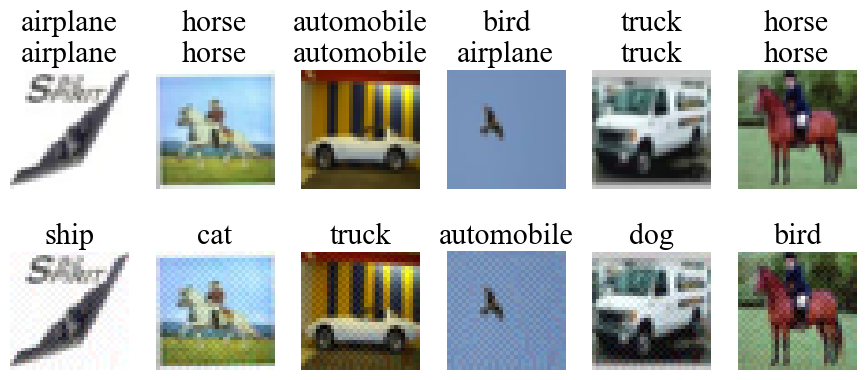

In [215]:
''' Non-targeted '''
adv_pred_list, uap = predict('_baselines/00')

# cln_good = (cln_pred_list == ground_truth_list).float()
# adv_good = (adv_pred_list == ground_truth_list).float()
# fool_yes = (cln_pred_list != adv_pred_list).float()

# indices1 = torch.nonzero(cln_good * fool_yes * (1-adv_good)).squeeze()
# indices2 = torch.nonzero((1-cln_good) * fool_yes * (1-adv_good)).squeeze()

# class_map1 = {}
# for i in indices1.tolist():
#     adv = adv_pred_list[i].item()
#     if adv in class_map1:
#         class_map1[adv].append(i)
#     else:
#         class_map1[adv] = [i]
# indices1 = torch.tensor([val[randint(0, len(val)-1)] for val in class_map1.values()])

# class_map2 = {}
# for i in indices2.tolist():
#     adv = adv_pred_list[i].item()
#     if adv in class_map2:
#         class_map2[adv].append(i)
#     else:
#         class_map2[adv] = [i]
# indices2 = torch.tensor([val[randint(0, len(val)-1)] for val in class_map2.values()])

# index_class_list1 = list(zip(indices1.tolist(), class_map1.keys()))
# index_class_list2 = list(zip(indices2.tolist(), class_map2.keys()))

# intersect_class = list(set.intersection(set(class_map1.keys()), set(class_map2.keys())))[0]
# indices1 = torch.tensor([item[0] for item in index_class_list1 if item[1] != intersect_class])
# indices2 = torch.tensor([item[0] for item in index_class_list2 if item[1] == intersect_class])
# indices = torch.cat([indices1, indices2])

# num_samples = (8, 1)
# indices = torch.cat([indices1[:num_samples[0]], indices2[:num_samples[1]]])

indices = torch.tensor([2959, 2326, 6381, 883, 3976, 3068])
print(indices.tolist())

num_samples = len(indices)
indices = indices[torch.randperm(num_samples)]
images = torch.stack([dataset[i][0] for i in indices])
adv_images = torch.clamp(images + uap, 
                         images.amin(dim=(0, 2, 3), keepdim=True), 
                         images.amax(dim=(0, 2, 3), keepdim=True))
labels = ground_truth_list[indices].tolist()
cln_pred = cln_pred_list[indices].tolist()
adv_pred = adv_pred_list[indices].tolist()

enumerator = enumerate(zip(tqdm(images), adv_images, labels, cln_pred, adv_pred), start=1)
plt.figure(figsize=(num_samples * 1.5, 4.5))
for i, (image, adv_image, label, cln, adv) in enumerator:
    ax = plt.subplot(2, num_samples, i)
    ax.set_title(f'{dataset.classes[label]}\n{dataset.classes[cln]}')
    ax.imshow(to_pil_image(image))
    ax.set_axis_off()
    
    ax = plt.subplot(2, num_samples, num_samples + i)
    ax.set_title(dataset.classes[adv])
    ax.imshow(to_pil_image(adv_image))
    ax.set_axis_off()
plt.tight_layout()

plt.savefig('vis/cifar10-nontarget.png')
plt.savefig('vis/cifar10-nontarget.pdf')
plt.show()

##### Visualize Perturbations (MNIST)

In [1]:
import os
from pathlib import Path
from tqdm.auto import tqdm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.size'] = 18

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_pil_image

import models, data

(gt, pred): (5, 5) (7, 7)
['10.00', '33.42', '56.84', '75.57', '99.00']


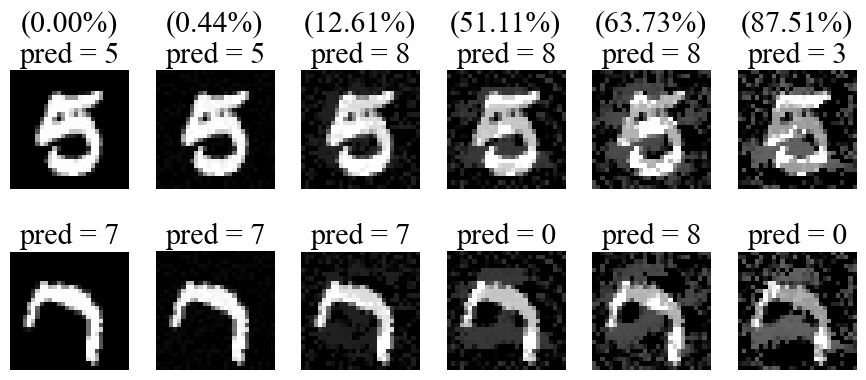

In [26]:
expdir = Path('./log/mnist_toy_1.0')
ckpt = torch.load(expdir.joinpath('ckpt.pth'))
net = models.get_model(ckpt['model']).eval()
out = net.load_state_dict(ckpt['net'])

dataset = data.get_dataset('mnist', train=False, transform=ToTensor())
sample_indices = [2162, 4102]

images, labels = zip(*[dataset[i] for i in sample_indices])

def predict(pert=0):
    inputs = torch.stack(images)
    inputs = torch.clamp(inputs + pert, 
                         min=inputs.amin(dim=(0, 2, 3), keepdim=True), 
                         max=inputs.amax(dim=(0, 2, 3), keepdim=True))
    return net(inputs).argmax(dim=1).tolist(), inputs

preds, _ = predict()
print('(gt, pred):', *zip(labels, preds))

budgetdir = expdir.joinpath('budgets')
budgets = sorted(os.listdir(budgetdir))
print(budgets)
num_budgets = len(budgets) + 1

plt.figure(figsize=(num_budgets * 1.5, 4.5))

ax = plt.subplot(2, num_budgets, 1)
ax.set_title(f'(0.00%)\npred = {preds[0]}')
ax.imshow(to_pil_image(images[0]), cmap='gray')
ax.set_axis_off()
ax = plt.subplot(2, num_budgets, num_budgets + 1)
ax.set_title(f'pred = {preds[1]}')
ax.imshow(to_pil_image(images[1]), cmap='gray')
ax.set_axis_off()

for i, budget in enumerate(budgets, start=2):
    filename = budgetdir.joinpath(budget, 'ckpt.pth')
    ckpt = torch.load(filename)
    fr = ckpt['fr']
    uap = ckpt['uap']
    adv_preds, adv_images = predict(uap)
    
    adv_images.shape
    ax = plt.subplot(2, num_budgets, i)
    ax.set_title(f'({fr:.2f}%)\npred = {adv_preds[0]}')
    ax.imshow(to_pil_image(adv_images[0]), cmap='gray')
    ax.set_axis_off()
    ax = plt.subplot(2, num_budgets, num_budgets+i)
    ax.set_title(f'pred = {adv_preds[1]}')
    ax.imshow(to_pil_image(adv_images[1]), cmap='gray')
    ax.set_axis_off()

plt.tight_layout()
plt.savefig('vis/mnist_budget.pdf')
plt.savefig('vis/mnist_budget.png')
plt.show()

In [11]:
loader = DataLoader(dataset, batch_size=1024)
gt = torch.tensor(dataset.targets)
all_cln_preds = []
all_adv_preds = []
for img, _ in tqdm(loader):
    inputs = torch.clamp(img + uap, 
                         min=img.amin(dim=(0, 2, 3), keepdim=True), 
                         max=img.amax(dim=(0, 2, 3), keepdim=True))
    all_cln_preds.append(net(img).argmax(dim=1))
    all_adv_preds.append(net(inputs).argmax(dim=1))
all_cln_preds = torch.cat(all_cln_preds)
all_adv_preds = torch.cat(all_adv_preds)

/tmp/ipykernel_36095/271241441.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt = torch.tensor(dataset.targets)


  0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
import pandas as pd

initial_correct = torch.eq(all_cln_preds, gt)  # Mask for initially correct classifications
misclassified = torch.ne(all_adv_preds, gt)  # Mask for misclassified instances after the attack
not_2_or_8 = torch.logical_and(torch.ne(all_adv_preds, 2), torch.ne(all_adv_preds, 8))  # Mask for attack results not equal to 2 or 8

indices = torch.nonzero(torch.logical_and(torch.logical_and(initial_correct, misclassified), not_2_or_8)).squeeze()
pd.DataFrame(torch.stack([indices, gt[indices], all_adv_preds[indices]], dim=1), 
             columns=['i', 'y', 'y_hat'])

,i,y,y_hat
0,782,3,5
1,1748,0,6
2,2162,5,3
3,3011,7,6
4,4102,7,0
5,4391,7,4
6,4397,3,5
7,4735,9,4
8,4910,9,4
9,5450,0,6
